In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
pd.set_option('display.max_columns', 500)
import lightgbm as lgb

## Rosbank ML Competition

Ссылка на соревнование: https://boosters.pro/champ_15

Росбанк – часть ведущей международной финансовой группы Societe Generale, банк включен ЦБ РФ в число 11 системно значимых кредитных организаций России. Инновации неотъемлемый процесс работы Росбанка, поэтому активно развивается направленный анализа больших данных.

- Данные

Датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

- Задача

Задача бинарной классификации – прогноз оттока клиентов

Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

In [2]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.head(5)
# target_sum - можно выкинуть, переменная участвует в другой задаче

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [3]:
raw_df.drop(['target_sum'], axis=1,inplace=True)

In [4]:
raw_df['target_flag'].value_counts()

1    320103
0    170410
Name: target_flag, dtype: int64

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   PERIOD        490513 non-null  object 
 1   cl_id         490513 non-null  int64  
 2   MCC           490513 non-null  int64  
 3   channel_type  487603 non-null  object 
 4   currency      490513 non-null  int64  
 5   TRDATETIME    490513 non-null  object 
 6   amount        490513 non-null  float64
 7   trx_category  490513 non-null  object 
 8   target_flag   490513 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 33.7+ MB


In [6]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [7]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [8]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  388337
Total transactions in test dataset:  102176


to_agg = ['sum','mean','std','median','max','min','count']
raw_df[raw_df['trx_category']=='POS'][['cl_id','amount']].groupby('cl_id').agg(to_agg).reset_index().fillna(0)

In [9]:
num_deals = transactions_train[['cl_id','amount']].groupby('cl_id').agg('count').reset_index()
num_deals.columns = ['cl_id','num_deals']
#num_deals.head()

In [10]:
sum_deals = transactions_train[['cl_id','amount']].groupby('cl_id').agg('sum').reset_index()
sum_deals.columns = ['cl_id','sum_deals']
df_train = pd.merge(num_deals, sum_deals, how='left', on='cl_id')
#sum_deals.head()

In [11]:
train_y = transactions_train[['cl_id','target_flag']].groupby('cl_id').agg('mean').reset_index()
train_y.columns = ['cl_id','target_flag']
df_train = pd.merge(df_train, train_y, how='left', on='cl_id')
#df_train.head()

In [12]:
#def mode_count(x):
#    return mode(x)[1][0]
to_agg = ['sum','mean','std','median','max','min','count']
for j in tqdm(pd.unique(transactions_train['trx_category'])):
    i = 'amount'
    temp = transactions_train[transactions_train['trx_category']==j][['cl_id',i]].groupby('cl_id').agg(to_agg).reset_index().fillna(0)
    new_cols = ['cl_id']
    for p in range(1,temp.columns.shape[0]):
        new_cols.append('trx_category'+'_'+str(j)+'_'+i+'_'+str(to_agg[p-1]))
    temp.columns = new_cols
    df_train = pd.merge(df_train, temp, how='left', on='cl_id')
    #df[str(j)+'_'+i+'_'+'count_frac'] = df[str(j)+'_'+i+'_'+'count'] / df['num_deals']

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 24.12it/s]


In [13]:
df_train.fillna(0)

,cl_id,num_deals,sum_deals,target_flag,trx_category_POS_amount_sum,trx_category_POS_amount_mean,trx_category_POS_amount_std,trx_category_POS_amount_median,trx_category_POS_amount_max,trx_category_POS_amount_min,trx_category_POS_amount_count,trx_category_DEPOSIT_amount_sum,trx_category_DEPOSIT_amount_mean,trx_category_DEPOSIT_amount_std,trx_category_DEPOSIT_amount_median,trx_category_DEPOSIT_amount_max,trx_category_DEPOSIT_amount_min,trx_category_DEPOSIT_amount_count,trx_category_C2C_OUT_amount_sum,trx_category_C2C_OUT_amount_mean,trx_category_C2C_OUT_amount_std,trx_category_C2C_OUT_amount_median,trx_category_C2C_OUT_amount_max,trx_category_C2C_OUT_amount_min,trx_category_C2C_OUT_amount_count,trx_category_WD_ATM_ROS_amount_sum,trx_category_WD_ATM_ROS_amount_mean,trx_category_WD_ATM_ROS_amount_std,trx_category_WD_ATM_ROS_amount_median,trx_category_WD_ATM_ROS_amount_max,trx_category_WD_ATM_ROS_amount_min,trx_category_WD_ATM_ROS_amount_count,trx_category_BACK_TRX_amount_sum,trx_category_BACK_TRX_amount_mean,trx_category_BACK_TRX_amount_std,trx_category_BACK_TRX_amount_median,trx_category_BACK_TRX_amount_max,trx_category_BACK_TRX_amount_min,trx_category_BACK_TRX_amount_count,trx_category_WD_ATM_PARTNER_amount_sum,trx_category_WD_ATM_PARTNER_amount_mean,trx_category_WD_ATM_PARTNER_amount_std,trx_category_WD_ATM_PARTNER_amount_median,trx_category_WD_ATM_PARTNER_amount_max,trx_category_WD_ATM_PARTNER_amount_min,trx_category_WD_ATM_PARTNER_amount_count,trx_category_WD_ATM_OTHER_amount_sum,trx_category_WD_ATM_OTHER_amount_mean,trx_category_WD_ATM_OTHER_amount_std,trx_category_WD_ATM_OTHER_amount_median,trx_category_WD_ATM_OTHER_amount_max,trx_category_WD_ATM_OTHER_amount_min,trx_category_WD_ATM_OTHER_amount_count,trx_category_C2C_IN_amount_sum,trx_category_C2C_IN_amount_mean,trx_category_C2C_IN_amount_std,trx_category_C2C_IN_amount_median,trx_category_C2C_IN_amount_max,trx_category_C2C_IN_amount_min,trx_category_C2C_IN_amount_count,trx_category_CAT_amount_sum,trx_category_CAT_amount_mean,trx_category_CAT_amount_std,trx_category_CAT_amount_median,trx_category_CAT_amount_max,trx_category_CAT_amount_min,trx_category_CAT_amount_count,trx_category_CASH_ADV_amount_sum,trx_category_CASH_ADV_amount_mean,trx_category_CASH_ADV_amount_std,trx_category_CASH_ADV_amount_median,trx_category_CASH_ADV_amount_max,trx_category_CASH_ADV_amount_min,trx_category_CASH_ADV_amount_count
0,0,5,64383.00,0,7821.00,2607.000000,2185.684332,2031.00,5023.00,767.00,3,20000.0,20000.000000,0.000000,20000.0,20000.0,20000.0,1.0,36562.00,36562.000000,0.000000,36562.0,36562.0,36562.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,104,267578.04,0,122578.04,1213.643960,6077.982642,300.00,60000.00,3.00,101,95000.0,47500.000000,3535.533906,47500.0,50000.0,45000.0,2.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,50000.0,50000.000000,0.000000,50000.0,50000.0,50000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,142,546369.13,1,290500.75,2617.123874,5887.016903,1214.90,56164.05,8.20,111,130000.0,32500.000000,5000.000000,30000.0,40000.0,30000.0,4.0,33878.38,4234.797500,2762.985251,4000.0,10000.0,1000.0,8.0,66500.0,4750.000000,4353.380649,2750.0,15000.0,1000.0,14.0,13990.0,13990.0,0.0,13990.0,13990.0,13990.0,1.0,6000.0,3000.0,2828.427125,3000.0,5000.0,1000.0,2.0,5500.0,2750.0,3181.980515,2750.0,5000.0,500.0,2.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,463,1124343.99,0,200956.11,537.315802,988.278994,230.75,11700.00,3.00,374,426300.0,17762.500000,11378.729680,15500.0,35000.0,1000.0,24.0,21692.90,1141.731579,3204.689372,370.0,14342.9,100.0,19.0,422300.0,10828.205128,33074.476952,1000

In [14]:
#df_train.info()

In [15]:
corr_matrix = df_train.corr()
corr_matrix["target_flag"].sort_values(ascending=False)

target_flag                             1.000000
num_deals                               0.253593
trx_category_CAT_amount_count           0.246724
trx_category_POS_amount_count           0.239797
trx_category_WD_ATM_ROS_amount_count    0.173708
                                          ...   
trx_category_CASH_ADV_amount_max       -0.368672
trx_category_CASH_ADV_amount_std       -0.386578
cl_id                                  -0.388060
trx_category_CASH_ADV_amount_count     -0.391293
trx_category_CASH_ADV_amount_sum       -0.406425
Name: target_flag, Length: 74, dtype: float64

In [16]:
from sklearn.model_selection import RepeatedStratifiedKFold
skf = RepeatedStratifiedKFold(n_splits=8, n_repeats=5, random_state=201805)

In [17]:
lgb_data_train = lgb.Dataset(df_train.drop(['target_flag'],axis=1), 
                             df_train['target_flag'], 
                             free_raw_data=False
                            )

params = {
    'objective':'binary', 
    'metric': 'auc',
    'learning_rate': 0.01, 
    'random_state':4242442,
    'subsample':0.33,
    'class_weight':'balanced',
    'colsample_bytree':0.33,
    'reg_lambda':4
}

h = lgb.cv(params, 
           lgb_data_train, 
           num_boost_round=10000,
           early_stopping_rounds=50, 
           verbose_eval=10, 
           folds=skf.split(df_train, df_train['target_flag'])
          )

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 1916, number of negative: 1584
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12434
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 66
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 1916, number of negative: 1584
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12434
[LightGBM] [Info] Number of data points in the train

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 1916, number of negative: 1584
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12434
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 66
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 1916, number of negative: 1584
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12434
[LightGBM] [Info] Number of data points in the train

[LightGBM] [Info] Start training from score 0.190286
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547429 -> initscore=0.190286
[LightGBM] [Info] Start training from score 0.190286
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547143 -> initscore=0.189133
[LightGBM] [Info] Start training from score 0.189133
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547143 -> initscore=0.189133
[LightGBM] [Info] Start training from score 0.189133
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547143 -> initscore=0.189133
[LightGBM] [Info] Start training from score 0.189133
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547143 -> initscore=0.189133
[LightGBM] [Info] Start training from score 0.189133
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547143 -> initscore=0.189133
[LightGBM] [Info] Start training from score 0.189133
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547429 -> initscore=0.190286
[LightGBM] [Info] Start training from score 0.190286
[LightGBM] [Info] [bina

In [ ]:
model = lgb.train(params, lgb_data_train, num_boost_round=490)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

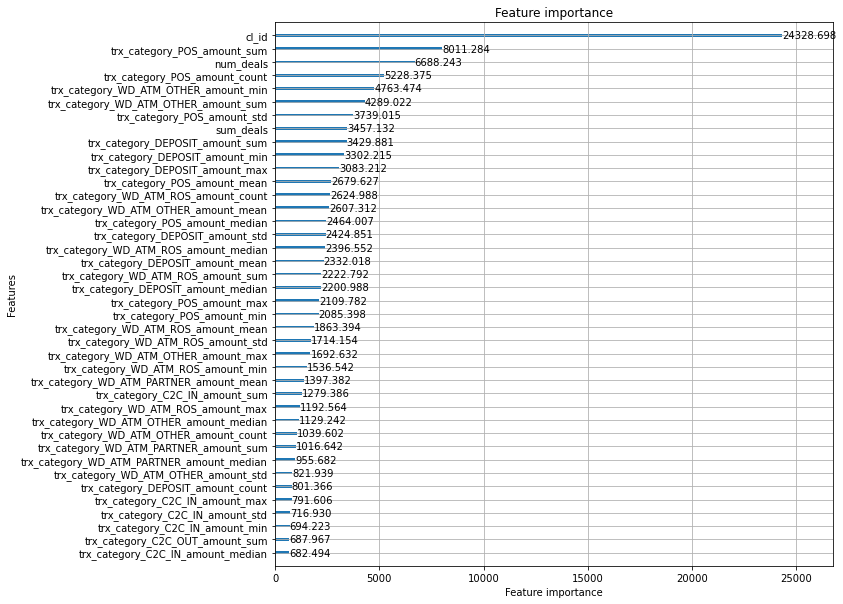

In [55]:
lgb.plot_importance(model, figsize=(10,10), importance_type='gain', max_num_features=40)

In [65]:
num_deals = transactions_test[['cl_id','amount']].groupby('cl_id').agg('count').reset_index()
num_deals.columns = ['cl_id','num_deals']
#num_deals.head()

In [66]:
sum_deals = transactions_test[['cl_id','amount']].groupby('cl_id').agg('sum').reset_index()
sum_deals.columns = ['cl_id','sum_deals']
df_test = pd.merge(num_deals, sum_deals, how='left', on='cl_id')
#sum_deals.head()

In [67]:
test_y = transactions_test[['cl_id','target_flag']].groupby('cl_id').agg('mean').reset_index()
test_y.columns = ['cl_id','target_flag']
df_test = pd.merge(df_test, test_y, how='left', on='cl_id')
#df_test.head()

In [37]:
to_agg = ['sum','mean','std','median','max','min','count']
for j in tqdm(pd.unique(transactions_test['trx_category'])):
    i = 'amount'
    temp = transactions_test[transactions_test['trx_category']==j][['cl_id',i]].groupby('cl_id').agg(to_agg).reset_index().fillna(0)
    new_cols = ['cl_id']
    for p in range(1,temp.columns.shape[0]):
        new_cols.append('trx_category'+'_'+str(j)+'_'+i+'_'+str(to_agg[p-1]))
    temp.columns = new_cols
    df_test = pd.merge(df_test, temp, how='left', on='cl_id')

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 55.39it/s]


In [52]:
df_test = df_test.fillna(0)
#df_test.info()

In [ ]:
y_hat = model.predict(df_test.drop(['target_flag'],axis=1))
sub = pd.DataFrame({
    '_ID_':df_test['cl_id'],
    '_VAL_': y_hat
})
sub.to_csv('1.csv',index=False)

In [45]:
from sklearn.metrics import r2_score
r2_score(df_test[['target_flag']], y_hat)

0.15005397050413805

In [46]:
from sklearn.metrics import average_precision_score
average_precision_score = average_precision_score( df_test[['target_flag']], y_hat )
average_precision_score

0.8099675291181485

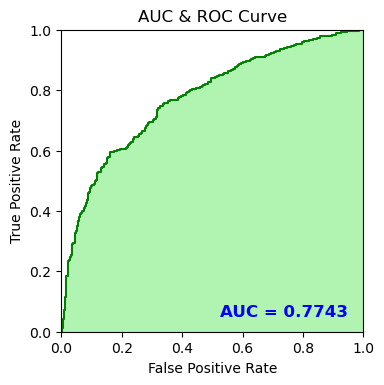

In [51]:
from sklearn import metrics
auc = metrics.roc_auc_score( df_test[['target_flag']], y_hat )

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve( df_test[['target_flag']], y_hat )

plt.figure(figsize=(5, 4), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()